/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Restoring parameters from ../CIFAR10_50/cifar10_model.ckpt-10
显示原图 1
loading ../cifar10_data/cifar-10-batches-py/data_batch_1
loading ../cifar10_data/cifar-10-batches-py/data_batch_2
loading ../cifar10_data/cifar-10-batches-py/data_batch_3
loading ../cifar10_data/cifar-10-batches-py/data_batch_4
loading ../cifar10_data/cifar-10-batches-py/data_batch_5
finished loadding CIFAR-10 data


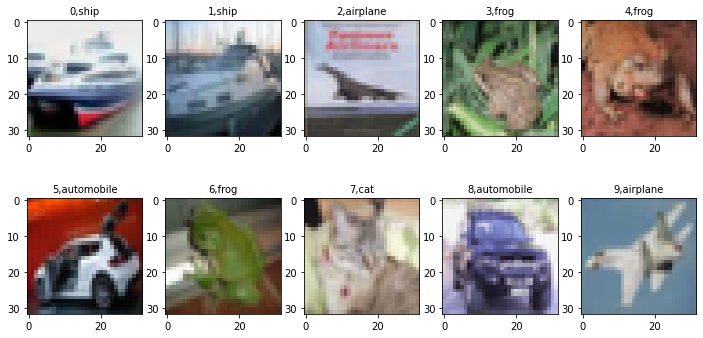

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import random

def weight(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.1),name='W')
def bias(shape):
    return tf.Variable(tf.constant(0.1,shape=shape),name='b')
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

# with tf.name_scope('input_layer'):
x = tf.placeholder('float',shape=[None,32,32,3],name='x_p')
with tf.name_scope('conv_1'):
    W1 = weight([3,3,3,32])
    b1 = bias([32])
    conv_1 = conv2d(x,W1)+b1
    conv_1 = tf.nn.relu(conv_1)
    
with tf.name_scope('pool_1'):
    pool_1 = max_pool_2x2(conv_1)
    
with tf.name_scope('conv_2'):
    W2 = weight([3,3,32,64])
    b2 = bias([64])
    conv_2=conv2d(pool_1,W2)+b2
    conv_2=tf.nn.relu(conv_2)
    
with tf.name_scope('pool_2'):
    pool_2 = max_pool_2x2(conv_2)
    
with tf.name_scope('fc'):
    W3 = weight([4096,128])
    b3 = bias([128])
    flat = tf.reshape(pool_2,[-1,4096])
    h= tf.nn.relu(tf.matmul(flat,W3)+b3)
    h_dropout = tf.nn.dropout(h,keep_prob=0.8)
# with tf.name_scope('output_layter'):
W4 = weight([128,10])
b4 = bias([10])
pred = tf.nn.softmax(tf.matmul(h_dropout,W4)+b4,name='pred_p')

with tf.name_scope('optimizer'):
    y = tf.placeholder('float',shape=[None,10],name='label')
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=pred,labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_function)
    

with tf.name_scope('evaluation'):
    correct_prediction = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))
    
sess = tf.Session()


saver = tf.train.Saver()

saver.restore(sess, "../CIFAR10_50/cifar10_model.ckpt-10") 

%matplotlib inline

def load_CIFAR_batch(filename):
    with open(filename,'rb')as f:
        data_dict = pickle.load(f,encoding='bytes')
        images = data_dict[b'data']
        labels = data_dict[b'labels']
        
        #把元数据结构调整为：BCWH
        images = images.reshape(10000,3,32,32)
        #tesorflow 处理图像数据的结构为：BWHC
        #把通道数据c移动到最后一个维度
        images = images.transpose(0,2,3,1)
        labels = np.array(labels)
        return images,labels
test_image,test_label = load_CIFAR_batch('../cifar10_data/cifar-10-batches-py/test_batch')
print('显示原图',test_label[6])
plt.imshow(test_image[6])


import os
def load_CIFAR_data(data_dir):
    images_train = []
    labels_train = []


    for i in range(5):
        # 循环读取，每一个文件的数据和标签名
        f = os.path.join(data_dir,'data_batch_%d'%(i+1))
        print('loading',f)
        image_batch,label_batch=load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain=np.concatenate(images_train)
        Ytrain=np.concatenate(labels_train)
        del image_batch,label_batch
    Xtest,Ytest = load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print("finished loadding CIFAR-10 data")
    return Xtrain,Ytrain,Xtest,Ytest
data_dir = '../cifar10_data/cifar-10-batches-py/'

Xtrain,Ytrain,Xtest,Ytest = load_CIFAR_data(data_dir)


label_dict = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
#定义显示图像数据以及对应标签的函数
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12,6)
    if num > 10:
        num=10
    for i in range(0,num):
        ax=plt.subplot(2,5,1+i)
        ax.imshow(images[idx],cmap='binary')
        
        title = str(i)+','+label_dict[labels[idx]]
        if len(prediction)>0:
            title+='=>'+label_dict[prediction[idx]]
        ax.set_title(title,fontsize=10)
        idx+=1
    plt.show()
    
plot_images_labels_prediction(Xtest,Ytest,[],1,10)

Xtest_normalize = Xtest.astype('float32')/255.0





In [ ]:
test_pred = sess.run('pred_p:0',feed_dict={'x_p:0':Xtest_normalize[0:2]})
print(test_pred)

本文档写了两种取session的方式  一种需要完全重写一遍graph定义代码  且必须和源代码一致  
另一种则不需要 重写graph定义代码 
关于报取不到ckpt文件的错误  详情可见 https://www.cnblogs.com/monologuesmw/p/12273727.html 这篇博客写的很详细


In [ ]:
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np


def imageprepare(): 
    im = Image.open('/root/cash_file/cifar10_testpic/1_4890.jpg') #读取的图片所在路径
    plt.imshow(im)  #显示需要识别的图片
    plt.show()
    print("这是原图im",im)
    
    im = im.convert('L')
    tv = list(im.getdata()) 
    print(len(tv))
    print("这是数据tv",tv)
    tva = [(255-x)*1.0/255.0 for x in tv] 
    print(len(tva))
    return tva
data = imageprepare()
# data1 = np.reshape([data],[32,32,3])
print(data1)

# tva = json.dumps(tva)

这是数据tv [(74, 79, 83), (62, 67, 71), (107, 118, 114), (122, 133, 129)]
灰度化后
L = R * 299/1000 + G * 587/1000+ B * 114/1000。
这是数据tv [78, 66, 114, 129]

输入是[[78, 66, 114, 129]]
tva = json.dumps(tva)

In [ ]:
def predict(sess,inputs):
#     preds = sess.run('pred:0', feed_dict={'X:0': inputs}) 
#     test_pred = sess.run(pred,feed_dict={x:inputs[:50]})
    #部署clipper时用这种写法
    test_pred = sess.run('pred:0',feed_dict={'x:0':inputs[:50]})

    prediction_result =sess.run(tf.argmax(test_pred,1))
    # `X` is used, it must be defined in the model with that name explicitly!
    return prediction_result
# predict(sess,Xtest_normalize)
print(Xtest_normalize.shape)
print(Xtest_normalize[0].shape)
print(Xtest_normalize[0])


# predict(sess,Xtest_normalize)

In [ ]:
sess

In [2]:
def predict1(sess,adds):
    import json
    num_imgs = len(adds)
#     print('这是啥',adds,num_imgs)
    result = []
    for i in range(num_imgs):
        data = json.loads(adds[i])
        test_pred = sess.run('pred_p:0',feed_dict={'x_p:0':data})
#         predints=sess.run('y_conv:0',feed_dict={"x:0":data,"keep_prob:0": 1.0})
        result.append(str(test_pred[0]))
    return result

In [3]:

from clipper_admin import ClipperConnection, DockerContainerManager
from clipper_admin.deployers.tensorflow import deploy_tensorflow_model
clipper_conn = ClipperConnection(DockerContainerManager())

In [4]:
clipper_conn.start_clipper()

20-06-15:03:55:49 INFO     [docker_container_manager.py:184] [default-cluster] Starting managed Redis instance in Docker
20-06-15:03:55:53 INFO     [docker_container_manager.py:276] [default-cluster] Metric Configuration Saved at /tmp/tmp_zo8ix6s.yml
20-06-15:03:55:55 INFO     [clipper_admin.py:162] [default-cluster] Clipper is running


In [5]:

clipper_conn.connect()

20-06-15:03:56:23 INFO     [clipper_admin.py:172] [default-cluster] Successfully connected to Clipper cluster at localhost:1337


In [6]:
clipper_conn.register_application(
    name="tf-app", input_type="strings", default_output="-1.0", slo_micros=100000)

20-06-15:03:56:27 INFO     [clipper_admin.py:236] [default-cluster] Application tf-app was successfully registered


In [7]:
deploy_tensorflow_model(
    clipper_conn,
    name="tf-mod",
    version=1,
    input_type="strings",
    func=predict1,
    tf_sess_or_saved_model_path=sess,
)

20-06-15:03:56:32 INFO     [deployer_utils.py:41] Saving function to /tmp/tmpu35yhy0kclipper
20-06-15:03:56:32 INFO     [deployer_utils.py:51] Serialized and supplied predict function
20-06-15:03:56:32 INFO     [tensorflow.py:196] TensorFlow model saved at: /tmp/tmpu35yhy0kclipper/tfmodel/model.ckpt 
20-06-15:03:56:32 INFO     [tensorflow.py:277] Using Python 3.6 base image
20-06-15:03:56:32 INFO     [clipper_admin.py:534] [default-cluster] Building model Docker image with model data from /tmp/tmpu35yhy0kclipper
20-06-15:03:56:33 INFO     [clipper_admin.py:539] [default-cluster] Step 1/2 : FROM clipper/tf36-container:0.4.1
20-06-15:03:56:33 INFO     [clipper_admin.py:539] [default-cluster]  ---> 3db42af800ff
20-06-15:03:56:33 INFO     [clipper_admin.py:539] [default-cluster] Step 2/2 : COPY /tmp/tmpu35yhy0kclipper /model/
20-06-15:03:56:33 INFO     [clipper_admin.py:539] [default-cluster]  ---> 72e3da796638
20-06-15:03:56:33 INFO     [clipper_admin.py:539] [default-cluster] Successfull

In [8]:
clipper_conn.link_model_to_app(
    app_name="tf-app",
    model_name="tf-mod")

20-06-15:03:56:39 INFO     [clipper_admin.py:303] [default-cluster] Model tf-mod is now linked to application tf-app


In [ ]:
clipper_conn.set_num_replicas("tf-mod", 2)

In [9]:
query_address = clipper_conn.get_query_addr()
print(query_address)

localhost:1337


In [ ]:
import matplotlib.pyplot as plt
import base64
import json
import requests
from PIL import Image

#官方json包 无法序列化 ndarray 和numpy.数据 故重写序列化功能 


class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, time):
            return obj.__str__()
        else:
            return super(NpEncoder, self).default(obj)




def query_json(addr,Xtest):
    url = "http://%s/tf-app/predict" % addr

    im = Image.open('/root/cash_file/cifar10_testpic/1_4927.jpg')
    plt.imshow(im)  #显示需要识别的图片
    plt.show()
#     im = im.convert('L')
    tv = im.getdata()
    print(tv)
#图像归一化 和训练数据保持一致
    tv = np.vstack(tv) / 255
#     tv = tv/255.0
#     np.array(tv).astype('float')/255.0
    print(tv)
    tva = [[(255-x)*1.0/255.0 for x in tv]]
    print(tva)
#     tva = json.dumps([Xtest],cls=MyEncoder)
    tva = json.dumps(tva)

    tva_j = json.dumps({"input": tva})
    headers = {'Content-type': 'application/json'}
    r = requests.post(url, headers=headers, data=tva_j)
    re = r.text
    global false, null, true

    false = null = true = ''
    ls = eval(re)
    print(ls)
#     numbers = ls['output']
#     numbers_str = numbers[1:-1]
#     numbers_str=numbers_str.replace("\n", "")
#     list1 = numbers_str.split(' ')
#     print("this number is "+ str(list1.index(max(list1))))
#     return (list1.index(max(list1)))
    return (ls)

In [ ]:
import matplotlib.pyplot as plt
import base64
import json
import requests
from PIL import Image
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, time):
            return obj.__str__()
        else:
            return super(NpEncoder, self).default(obj)
        
def query_json(addr,Xtest):
    url = "http://%s/tf-app/predict" % addr

    datas = [Xtest]

    datas_js = json.dumps(datas,cls=MyEncoder)

    data_input = json.dumps({"input":datas_js})
    headers = {'Content-type': 'application/json'}
    r = requests.post(url, headers=headers, data=data_input)
    re = r.text
    global false, null, true

    false = null = true = ''
    ls = eval(re)
    print(ls)
#     numbers = ls['output']
#     numbers_str = numbers[1:-1]
#     numbers_str=numbers_str.replace("\n", "")
#     list1 = numbers_str.split(' ')
#     print("this number is "+ str(list1.index(max(list1))))
#     return (list1.index(max(list1)))
    return (ls)

In [65]:
import matplotlib.pyplot as plt
import base64
import json
import requests
from PIL import Image

#官方json包 无法序列化 ndarray 和numpy.数据 故重写序列化功能 


class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, time):
            return obj.__str__()
        else:
            return super(NpEncoder, self).default(obj)

def pred_num(txt):
    global false, null, true

    false = null = true = ''
    ls = eval(txt)
    print(ls)
    numbers = ls['output']
    print(numbers,len(numbers))
    numbers_str = numbers[1:-1]
    numbers_str=numbers_str.replace("\n", " ")
    numbers_str=numbers_str.replace("  ", " ")
    acc_list = []
    i = 0
    while i<= 9:
#     for i in range(0,11):
        number1 = numbers_str[(i*15):15*(i+1)]
#         print('这是神',number1)
        acc_list.append(float(number1))
        i+=1
    return (acc_list)
# pred_num(numbers_str)
# def pred_num1(txt):
#     global false, null, true

#     false = null = true = ''
#     ls = eval(txt)
#     print(ls)
#     numbers = ls['output'][1:-1]
#     num1 = np.array(numbers)
# #     num1 = tf.argmax(numbers)
# #     print(numbers,len(numbers))
# #     numbers_str = numbers[1:-1]
# #     acc_list = []
# #     for i in range(0,11):
# #         number1 = numbers_str[(i*15):15*(i+1)]
# #         print('这是神',number1)
# #         acc_list.append(float(number1))
# #         i+=1
#     print(np.argmax(num1))
#     return num1

def query_json(addr,Xtest):
    url = "http://%s/tf-app/predict" % addr

    im = Image.open(Xtest)
    plt.imshow(im)  #显示需要识别的图片
    plt.show()
    # im = im.convert('L')
    tv = list(im.getdata())
#     print(tv)
    tva_float=[]
    for i in tv:
        tva = [(255-x)*1.0/255.0 for x in i]
        tva_float.append(tva)
# print(tva_float)
    tva_float = np.array(tva_float).reshape(1,32,32,3)
    tva = tva_float

#     print(tva)
#     tva = json.dumps([Xtest],cls=MyEncoder)
    tva = json.dumps(tva,cls=MyEncoder)

    tva_j = json.dumps({"input": tva})
    headers = {'Content-type': 'application/json'}
    r = requests.post(url, headers=headers, data=tva_j)
    re = r.text
    acc_list = pred_num(re)
    maa = acc_list.index(max(acc_list))
    label_dict = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
    str1 = '这是个 '+label_dict[maa]
    print(maa)
#     global false, null, true

#     false = null = true = ''
#     ls = eval(re)
#     print(ls)
#     numbers = ls['output']
#     print(numbers,len(numbers))
#     numbers_str = numbers[1:-1]
#     acc_list = []

#     print(numbers_str,len(numbers_str))
#     numbers_str=numbers_str.replace("\n", "")
#     list1 = numbers_str.split(' ')
#     print("this number is "+ str(list1.index(max(list1))))
#     return (list1.index(max(list1)))
    return str1



In [88]:
import matplotlib.pyplot as plt
import base64
import json
import requests
from PIL import Image
from datetime import datetime


#官方json包 无法序列化 ndarray 和numpy.数据 故重写序列化功能 


class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, time):
            return obj.__str__()
        else:
            return super(NpEncoder, self).default(obj)

def pred_num(txt):
    global false, null, true

    false = null = true = ''
    ls = eval(txt)
#     print(ls)
    numbers = ls['output']
#     print(numbers,len(numbers))
    bt = len(numbers)//10
#     print(bt)
    numbers_str = numbers[1:-1]
    numbers_str=numbers_str.replace("\n", " ")
    numbers_str=numbers_str.replace("  ", " ")

    acc_list = []
    i = 0
    while i<= 9:
        number1 = numbers_str[(i*bt):bt*(i+1)]
#         print('这是神',number1)
        acc_list.append(float(number1))
        i+=1
    return (acc_list)

def query_json(addr,Xtest):
    url = "http://%s/tf-app/predict" % addr

    label_number = int(Xtest[32])
    im = Image.open(Xtest)
    plt.imshow(im)  #显示需要识别的图片
    plt.show()
    tv = list(im.getdata())
#     print(tv)
    tva_float=[]
    for i in tv:
        tva = [(255-x)*1.0/255.0 for x in i]
        tva_float.append(tva)
    tva_float = np.array(tva_float).reshape(1,32,32,3)
    tva = tva_float

    tva = json.dumps(tva,cls=MyEncoder)

    tva_j = json.dumps({"input": tva})
    headers = {'Content-type': 'application/json'}
    start = datetime.now()
    r = requests.post(url, headers=headers, data=tva_j)
    end = datetime.now()
    latency = (end - start).total_seconds() * 1000.0
    re = r.text
    acc_list = pred_num(re)
    maa = acc_list.index(max(acc_list))
    label_dict = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
    str1 = '模型推测这是个 '+label_dict[maa]+' 其实这是个 '+label_dict[label_number] +" 预测延迟是   " + str(latency) +" 毫秒 "
#     print(maa)
    return str1



In [25]:
def pred_num(txt):
    global false, null, true

    false = null = true = ''
    ls = eval(re)
    print(ls)
    numbers = ls['output']
    print(numbers,len(numbers))
    numbers_str = numbers[1:-1]
    acc_list = []
    for i in range(0,11):
        number1 = numbers_str[i*15,15*(i+1)]
        acc_list.append(int(number1))
        i+=1
    return (acc_list)
pred_num(numbers_str)

NameError: name 'numbers_str' is not defined

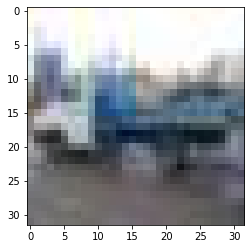

'模型推测这是个 cat 其实这是个 truck 预测延迟是   6.3709999999999996 毫秒 '

In [89]:
# inputs = [Xtest_normalize[0],Xtest_normalize[1]]
# inputs = Xtest_normalize[0:2]
# inputs = Xtest_normalize[0]
# inputs = [[[0.2,0.5,0.6]]]

add1 = "/root/cash_file/cifar10_testpic/9_787.jpg"

# print(type(inputs))
query_json(query_address, add1)
#输入维度不对  会报   'No connected models found for query'是因为 容器自动关闭了 怀疑是系统bug   估计还是 输入问题 
#但是 按照我的理解 输入 又报 预测超时 换了数据 又会报上面的错 
#容器自动关闭 对比  mnist数据集的预测与 模型容器  会处于 一直接受数据的状态 

目前容器请求一次后 容器自动关闭 对比  mnist数据集的预测与 模型容器  会处于 一直接受数据的状态 

Received heartbeat!
Sent heartbeat!
Received heartbeat!
Got start of message 2 
recv: 0.000441 s, parse: 0.000011 s, handle: 0.008508 s
Sent heartbeat!
Received heartbeat!



In [ ]:
inputs = []
input1 = [Xtest_normalize[0]]
def predict1(sess,adds):
    import json
    num_imgs = len(adds)
    result = []
    for i in range(num_imgs):
        data = json.loads(adds[i])
        test_pred = sess.run('pred_p:0',feed_dict={'x_p:0':adds[i]})
#         predints=sess.run('y_conv:0',feed_dict={"x:0":data,"keep_prob:0": 1.0})
        result.append(str(test_pred[0]))
    return result
tva = json.dumps(input1,cls=MyEncoder)
tva_j = json.dumps({"input": tva})
data = json.loads(tva_j)
data1 = json.loads(data)

print(data)
# predict1(sess,tva)

# 由原来运行通的 例子 推测 clipper对输入列表下进行反序列化 取到键input的值
# 放到预测函数额的输入位置  通过 部署的容器 id 查看日志 可以看到 报错信息    输入到 clipper内部 交给 预测函数  

In [90]:
clipper_conn.stop_all()

20-06-15:05:54:49 INFO     [clipper_admin.py:1424] [default-cluster] Stopped all Clipper cluster and all model containers


In [ ]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, time):
            return obj.__str__()
        else:
            return super(NpEncoder, self).default(obj)


ls = json.dumps([Xtest_normalize[0],Xtest_normalize[1]], cls=MyEncoder) 
ls1 = json.loads(ls)
print(ls1)
# ls = '124'
# ls1 = list(ls)
# print(ls1)
# print(eval(ls))
# listt1 = [[[[1,2],[3,4]]]]
# jj = json.dumps(listt1)
# print(jj)
# print(type(listt1))
# print(Xtest_normalize[0])
# print(type(Xtest_normalize[0]))
# list2 = list(Xtest_normalize[0])
# jj = json.dumps(list2)
# print(type(list2))
# print(np.array(list2))

#从clipper的使用为出发点 外围数据 传入clipper 需要 用到json转换 但json不支持对 numpy.ndarray的转换 故 基本确定思路是 需要  
#先把外围图像数据 转化为 列表 包裹 》》 json转换 》》到达clipper 》》在进行逐一预测 
# print(Xtest_normalize[0][0][0])

# print(Xtest_normalize[0][0][0][0])

In [ ]:
Xtest_normalize[0]

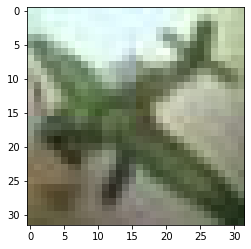

[(213, 246, 235), (210, 243, 232), (220, 251, 243), (226, 255, 251), (219, 248, 243), (218, 247, 243), (225, 251, 250), (224, 250, 251), (228, 254, 255), (225, 249, 253), (223, 248, 252), (226, 251, 255), (230, 255, 255), (229, 254, 255), (223, 251, 254), (220, 248, 251), (220, 246, 255), (234, 255, 255), (226, 251, 255), (220, 245, 249), (231, 255, 253), (228, 251, 241), (220, 244, 228), (231, 255, 233), (223, 246, 220), (219, 239, 211), (209, 228, 196), (218, 238, 203), (200, 217, 183), (209, 225, 189), (193, 209, 173), (183, 199, 163), (204, 238, 224), (209, 241, 230), (225, 255, 246), (233, 255, 255), (227, 255, 251), (227, 255, 252), (233, 255, 255), (229, 255, 254), (229, 255, 255), (225, 249, 251), (221, 247, 248), (221, 246, 250), (224, 249, 253), (227, 252, 255), (229, 254, 255), (230, 255, 255), (228, 252, 255), (227, 251, 255), (224, 249, 255), (228, 252, 254), (230, 255, 251), (223, 246, 236), (225, 248, 232), (241, 255, 242), (224, 247, 219), (184, 205, 174), (165, 184, 15

In [24]:
im = Image.open("/root/cash_file/cifar10_testpic/0_27.jpg")
plt.imshow(im)  #显示需要识别的图片
plt.show()
# im = im.convert('L')
tv = list(im.getdata())
print(tv)
tva_float=[]
for i in tv:
    tva = [(255-x)*1.0/255.0 for x in i]
    tva_float.append(tva)
# print(tva_float)
tva_float = np.array(tva_float).reshape(1,32,32,3)
tva = tva_float

test_pred = sess.run('pred_p:0',feed_dict={'x_p:0':tva})
print(test_pred,len(test_pred[0]))